# UC San Diego: Data Science in Practice - EDA Checkpoint
### Summer Session I 2023 | Instructor : C. Alex Simpkins Ph.D.

## Identifying Relationships in Diabetes Clinical Data Towards Predicting Blood Glucose Levels.

# Names

- Conner Hsu
- Harshita Saha
- Sidharth Srinath
- Anastasiya Markova

<a id='research_question'></a>
# Research Question

Given clinical data for cohorts with and without diabetes, which feature most correlates to the measure of 'blood_glucose_level' for each cohort, and are they different between the cohorts?

# Setup and Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Data Cleaning

Describe your data cleaning steps here.

In [3]:
# check if there is any missing data
df.isna().sum().sum()

0

In [4]:
# check the datatypes of each column
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [5]:
# checking gender of patients
df.groupby('gender').count()['age']

gender
Female    58552
Male      41430
Other        18
Name: age, dtype: int64

In [6]:
# removing records where gender is not specified/recorded as it may affect predictions
df = df[df['gender'] != 'Other']
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [7]:
# removing records for patients less than 20
# this is because the rates of diabetes are lower in these populations
# and diabetes is less well studied as a result, and analyis based 
# on these groups might not generalizable
# https://www.cdc.gov/diabetes/data/statistics-report/newly-diagnosed-diabetes.html
# https://diabetesjournals.org/care/article/46/3/490/148482/Youth-Onset-Type-2-Diabetes-The-Epidemiology-of-an
df = df[df['age'] >= 20]
df.shape

(80321, 9)

In [8]:
# bmi labeling
bmi_bins = pd.cut(df['bmi'], [0, 18.5, 25, 30, round(df['bmi'].max())], right=False, \
                 labels=['underweight', 'healthy', 'overweight', 'obese']) 
df['bmi_label'] = bmi_bins

In [9]:
# blood_glucose labeling
bg_bins = pd.cut(df['blood_glucose_level'], [0, 90, 130, round(df['blood_glucose_level'].max())], right=False, \
                labels=['low', 'normal', 'high'])
df['bg_label'] = bg_bins

In [10]:
# HbA1c labeling
age_bins = pd.cut(df['age'], [19, 39, 59, round(df['age'].max())], labels=['g1', 'g2', 'g3'])
df['age_label'] = age_bins

#setting up thresholds for HbA1c levels
conditions = [df['age_label']=='g1', df['age_label']=='g2', df['age_label']=='g3']
choices = [6.0, 6.1, 6.5]
HbA1c_exp = np.select(conditions, choices)
df['HbA1c_label'] = HbA1c_exp

#assigning high/normal based on the thresholds and current HbA1c levels
df['HbA1c_label'] = (df['HbA1c_level'] <= df['HbA1c_label']).replace({True:'normal', False:'high'})
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_label,bg_label,age_label,HbA1c_label
0,Female,80.0,0,1,never,25.19,6.6,140,0,overweight,high,g3,high
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,overweight,low,g2,high
2,Male,28.0,0,0,never,27.32,5.7,158,0,overweight,high,g1,normal
3,Female,36.0,0,0,current,23.45,5.0,155,0,healthy,high,g1,normal
4,Male,76.0,1,1,current,20.14,4.8,155,0,healthy,high,g3,normal


In [11]:
#reorderingthe columns
df = df[list(df.columns[:6])+['bmi_label', 'HbA1c_level', 'HbA1c_label', 'blood_glucose_level', 'bg_label', 'diabetes']]
#renaming the columns
df = df.rename(columns={"HbA1c_level": "hba1c", "HbA1c_label": "hba1c_label", "blood_glucose_level": "bg"})
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,bmi_label,hba1c,hba1c_label,bg,bg_label,diabetes
0,Female,80.0,0,1,never,25.19,overweight,6.6,high,140,high,0
1,Female,54.0,0,0,No Info,27.32,overweight,6.6,high,80,low,0
2,Male,28.0,0,0,never,27.32,overweight,5.7,normal,158,high,0
3,Female,36.0,0,0,current,23.45,healthy,5.0,normal,155,high,0
4,Male,76.0,1,1,current,20.14,healthy,4.8,normal,155,high,0


In [12]:
df0 = df[df['diabetes'] == 0]
df1 = df[df['diabetes'] == 1]

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [13]:
df.describe()

,age,hypertension,heart_disease,bmi,hba1c,bg,diabetes
count,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000
mean,49.782946,0.093064,0.049003,28.711241,5.555272,139.280101,0.104506
std,17.478788,0.290524,0.215876,6.057741,1.090123,41.974772,0.305917
min,20.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,35.000000,0.000000,0.000000,25.700000,4.800000,100.000000,0.000000
50%,49.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,63.000000,0.000000,0.000000,30.750000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,1.000000


In [14]:
# proportion of 'hypertension', 'heart_disease', 'diabetes' by gender
#df.groupby(['gender']).agg('mean')[['hypertension', 'heart_disease', 'diabetes']]
list(df.columns)

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'smoking_history',
 'bmi',
 'bmi_label',
 'hba1c',
 'hba1c_label',
 'bg',
 'bg_label',
 'diabetes']

In [15]:
df.dtypes

gender               object
age                 float64
hypertension          int64
heart_disease         int64
smoking_history      object
bmi                 float64
bmi_label          category
hba1c               float64
hba1c_label          object
bg                    int64
bg_label           category
diabetes              int64
dtype: object

## Bar Charts and Box Plots

In [16]:
tmp = df.groupby('heart_disease')['hypertension', 'diabetes'].mean()
tmp.reset_index(inplace=True)
tmp

/var/folders/r1/mts_mntx0m58jz5ml1zlfcjw0000gn/T/ipykernel_79824/3531350910.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df.groupby('heart_disease')['hypertension', 'diabetes'].mean()


,heart_disease,hypertension,diabetes
0,0,0.085868,0.093317
1,1,0.232724,0.321646


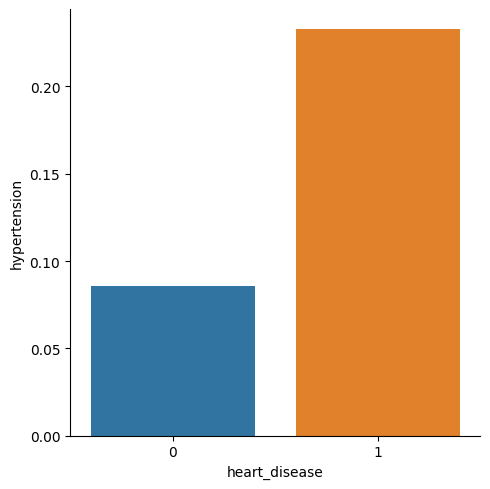

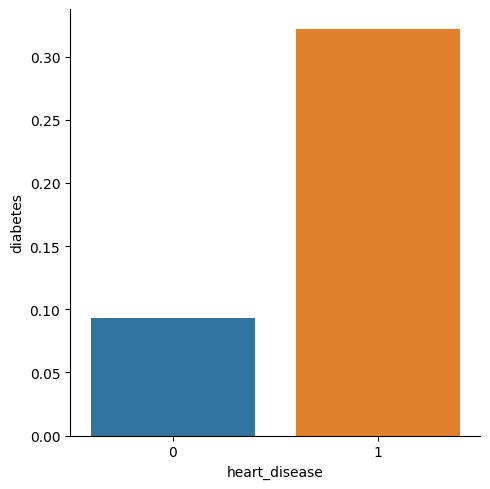

In [17]:
sns.catplot(data=tmp, kind="bar", x='heart_disease', y="hypertension")
sns.catplot(data=tmp, kind="bar", x='heart_disease', y='diabetes')

In [18]:
# proportion of 'heart_disease', 'diabetes' by hypertension status
tmp = df.groupby('hypertension')['heart_disease', 'diabetes'].mean()
tmp.reset_index(inplace=True)
tmp

/var/folders/r1/mts_mntx0m58jz5ml1zlfcjw0000gn/T/ipykernel_79824/910073246.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df.groupby('hypertension')['heart_disease', 'diabetes'].mean()


,hypertension,heart_disease,diabetes
0,0,0.041457,0.086566
1,1,0.122542,0.279331


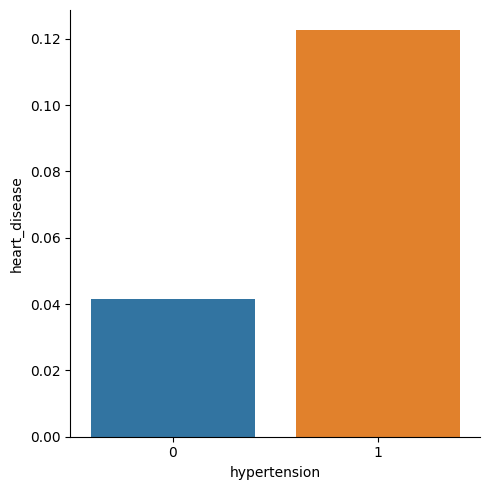

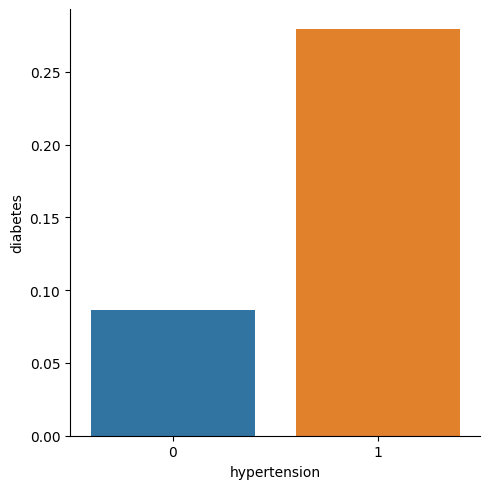

In [19]:
sns.catplot(data=tmp, kind="bar", x='hypertension', y="heart_disease")
sns.catplot(data=tmp, kind="bar", x='hypertension', y='diabetes')

In [52]:
tmp = df0.groupby('bmi_label')['diabetes'].count()
tmp2 = df1.groupby('bmi_label')['diabetes'].count()
tmp = pd.concat([tmp, tmp2], axis=1)
tmp.reset_index(inplace=True)
tmp.columns = ['bmi_label', 'nondiabetic','diabetic']
tmp['nondiabetic'] = tmp['nondiabetic']/tmp['nondiabetic'].sum()
tmp['diabetic'] = tmp['diabetic']/tmp['diabetic'].sum()
tmp

,bmi_label,nondiabetic,diabetic
0,underweight,0.012360,0.005004
1,healthy,0.215941,0.097331
2,overweight,0.517469,0.394568
3,obese,0.254230,0.503097


Text(0.5, 1.0, 'BMI label distribution for diabetic patients')

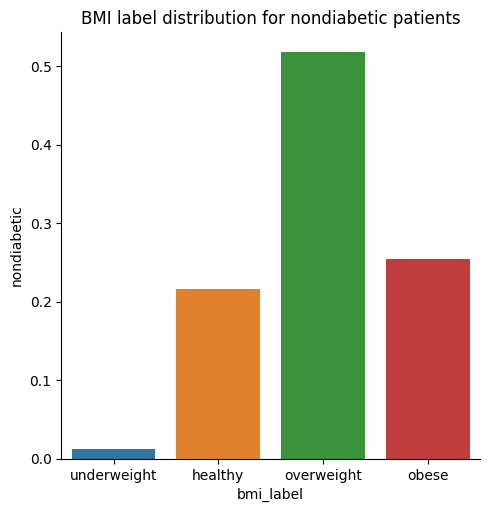

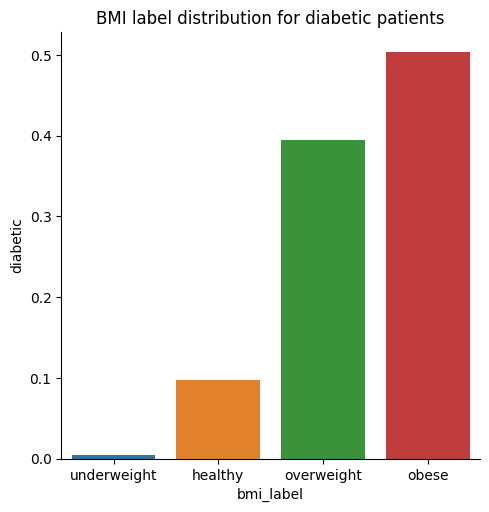

In [53]:
sns.catplot(data=tmp, kind="bar", x='bmi_label', y='nondiabetic')
plt.title('BMI label distribution for nondiabetic patients')
sns.catplot(data=tmp, kind="bar", x='bmi_label', y='diabetic')
plt.title('BMI label distribution for diabetic patients')

In [54]:
tmp = df0.groupby('bg_label')['diabetes'].count()
tmp2 = df1.groupby('bg_label')['diabetes'].count()
tmp = pd.concat([tmp, tmp2], axis=1)
tmp.reset_index(inplace=True)
tmp.columns = ['bg_label', 'nondiabetic','diabetic']
tmp['nondiabetic'] = tmp['nondiabetic']/tmp['nondiabetic'].sum()
tmp['diabetic'] = tmp['diabetic']/tmp['diabetic'].sum()
tmp

,bg_label,nondiabetic,diabetic
0,low,0.152669,0.000000
1,normal,0.232124,0.080875
2,high,0.615207,0.919125


Text(0.5, 1.0, 'Blood glucose label distribution for diabetic patients')

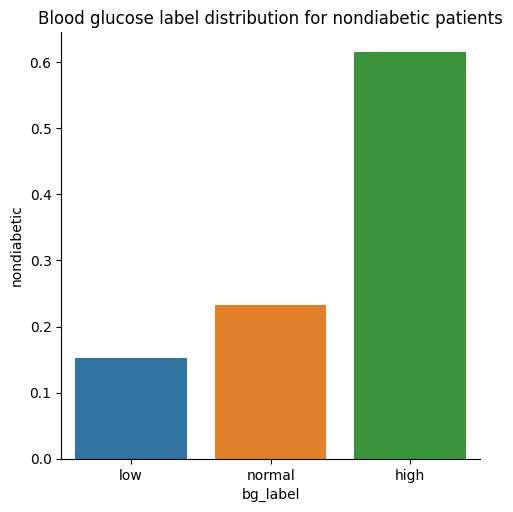

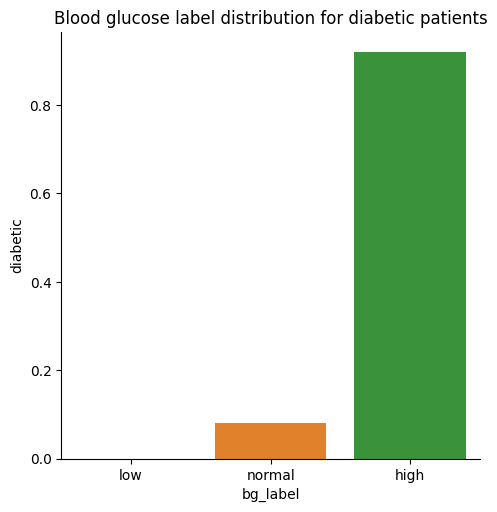

In [55]:
sns.catplot(data=tmp, kind="bar", x='bg_label', y='nondiabetic')
plt.title('Blood glucose label distribution for nondiabetic patients')
sns.catplot(data=tmp, kind="bar", x='bg_label', y='diabetic')
plt.title('Blood glucose label distribution for diabetic patients')

In [56]:
tmp = df0.groupby('hba1c_label')['diabetes'].count()
tmp2 = df1.groupby('hba1c_label')['diabetes'].count()
tmp = pd.concat([tmp, tmp2], axis=1)
tmp.reset_index(inplace=True)
tmp.columns = ['hba1c_label', 'nondiabetic','diabetic']
tmp['nondiabetic'] = tmp['nondiabetic']/tmp['nondiabetic'].sum()
tmp['diabetic'] = tmp['diabetic']/tmp['diabetic'].sum()
tmp

,hba1c_label,nondiabetic,diabetic
0,high,0.233515,0.605552
1,normal,0.766485,0.394448


Text(0.5, 1.0, 'HbA1c label distribution for diabetic patients')

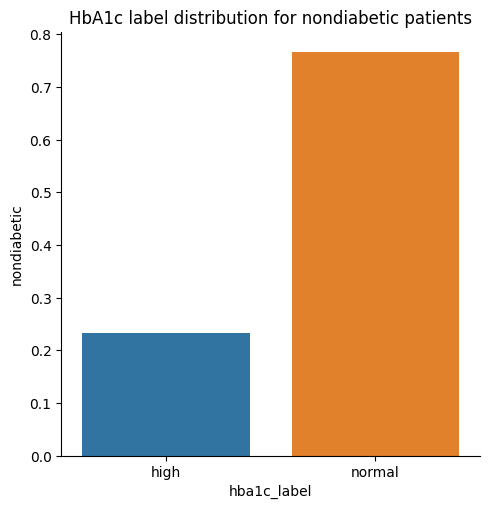

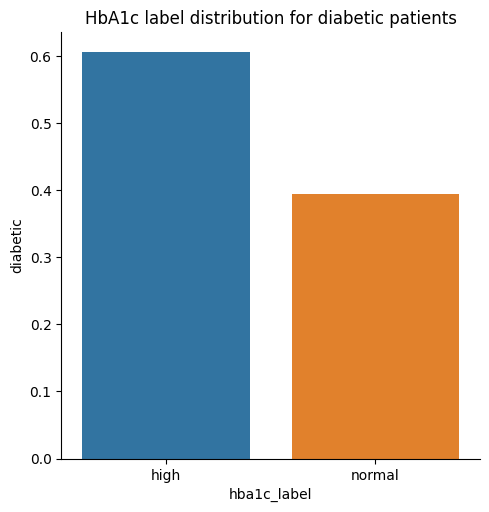

In [57]:
sns.catplot(data=tmp, kind="bar", x='hba1c_label', y='nondiabetic')
plt.title('HbA1c label distribution for nondiabetic patients')
sns.catplot(data=tmp, kind="bar", x='hba1c_label', y='diabetic')
plt.title('HbA1c label distribution for diabetic patients')

<AxesSubplot: xlabel='age', ylabel='bg_label'>

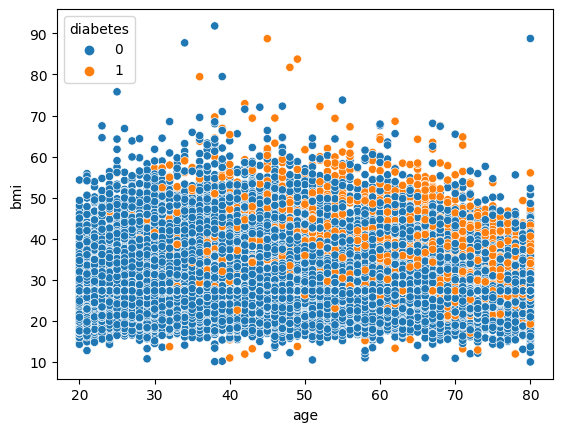

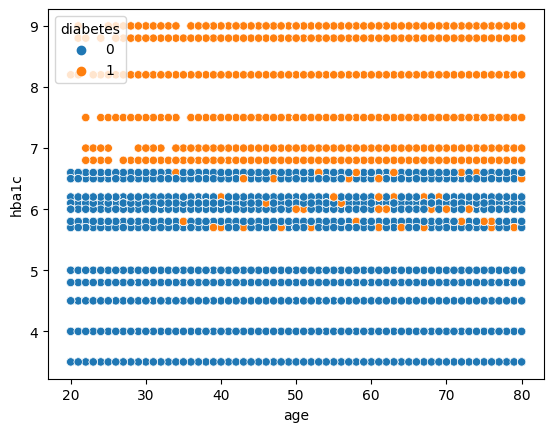

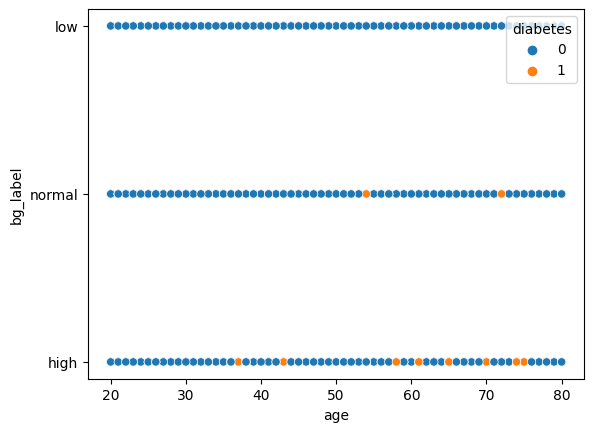

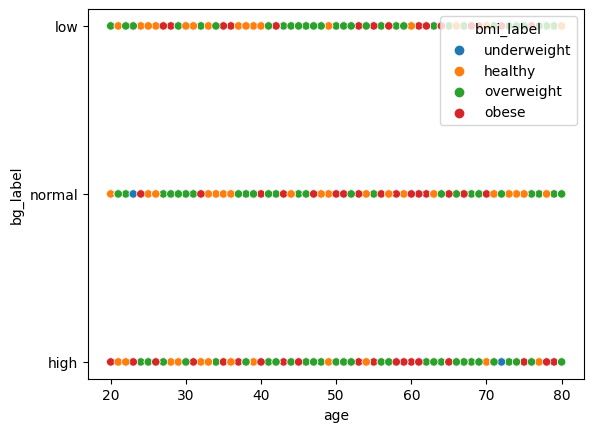

In [60]:
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df); plt.figure()
sns.scatterplot(x='age', y='hba1c', hue='diabetes', data=df); plt.figure()
sns.scatterplot(x='age', y='bg_label', hue='diabetes', data=df); plt.figure()
sns.scatterplot(x='age', y='bg_label', hue='bmi_label', data=df)

In [ ]:
gen_hyp = (df.groupby(['gender'])['hypertension']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .rename({0:'No',1:"Yes"})
                        .reset_index()
)
gen_hd = (df.groupby(['gender'])['heart_disease']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .rename({0:'No',1:"Yes"})
                        .reset_index()
)
gen_d = (df.groupby(['gender'])['diabetes']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .rename({0:'No',1:"Yes"})
                        .reset_index()
)
fig, axs = plt.subplots(ncols=3,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='hypertension',y='proportion',hue='gender',data=gen_hyp,ax=axs[0])
sns.barplot(x='heart_disease',y='proportion',hue='gender',data=gen_hd,ax=axs[1])
sns.barplot(x='diabetes',y='proportion',hue='gender',data=gen_d,ax=axs[2])

Here we can see that females are represented more than males in incidences of hypertension, heart disease, and diabetes

In [ ]:
# average 'age', 'bmi', 'HbA1c_level', 'blood_glucose_level' by gender
gen_age = (df.groupby(['gender'])['age']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .reset_index()
)

gen_bmi = (df.groupby(['gender'])['bmi']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .reset_index()
)

gen_hba = (df.groupby(['gender'])['hba1c']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .reset_index()
)
gen_bgl= (df.groupby(['gender'])['bg']
                        .value_counts(normalize=True)
                        .rename('proportion')
                        .reset_index()
)
fig, axs = plt.subplots(nrows=4,figsize=(8,8))
fig.tight_layout()
sns.histplot(x='age',y='proportion',hue='gender',data=gen_age, ax=axs[0])
sns.lineplot(x='bmi',y='proportion', hue='gender',data=gen_bmi,ax=axs[1])
sns.histplot(x='hba1c',y='proportion',hue='gender',data=gen_hba,ax=axs[2])
sns.histplot(x='bg',y='proportion',hue='gender',data=gen_bgl,ax=axs[3])

Here we can see:
1. Females are represented more than males across most ages.
2. Females are represnted more than males across all bmis.
3. Females are represented more than males across higher hba1c levels and similarly with males in lower levels.
4. Females are represnted more than males across all bg levels.

In [ ]:
# proportion of 'hypertension', 'heart_disease' by diabetes status and gender
dg_hthd = df.groupby(['diabetes', 'gender'])[['hypertension', 'heart_disease']].mean().rename({'Female':1,'Male':0}).reset_index()
labels = ['Females w/o diabetes','Males w/o diabetes','Females w/ diabetes', 'Males w/ diabetes']
dg_hthd['labels'] = labels
fig, axs = plt.subplots(nrows=2,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='labels',y='hypertension',data=dg_hthd, ax=axs[0])
sns.barplot(x='labels',y='heart_disease',data=dg_hthd, ax=axs[1])

Here we can see that females w/ diabetes are represented more than males w/ diabetes in incidences of hypertension males w/diabetes are represnted more than females w/ diabetes in incidences of heart disease.

In [ ]:
data2 = df.groupby(['diabetes', 'gender'])[['age', 'bmi', 'hba1c', 'bg']].mean().reset_index()
labels = ['Females w/o diabetes','Males w/o diabetes','Females w/ diabetes', 'Males w/ diabetes']
data2['labels'] = labels

fig, axs = plt.subplots(nrows=4,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='labels',y='age',data=data2, ax=axs[0])
sns.barplot(x='labels',y='bmi',data=data2, ax=axs[1])
sns.barplot(x='labels',y='hba1c',data=data2, ax=axs[2])
sns.barplot(x='labels',y='bg',data=data2, ax=axs[3])

Here we can see that across females and males w/ and w/o diabetes, those in either sex with diabetes are represented more than those without for features, age, bmi, hba1c level, and blood glucose level. Additionally, we can see that there is not much of a difference in representation across these features between sexes.

In [ ]:
# create age group bins to explore features by age group
# justify and/or change ages chosen here
bins = pd.cut(df['age'], [0, 5, 13, 18, 30, 45, 60, 80]) 
df['age_group'] = bins

In [ ]:
# proportion of 'hypertension', 'heart_disease', 'diabetes' by age group
data3 = df.groupby(['age_group'])[['hypertension', 'heart_disease']].mean().reset_index()

fig, axs = plt.subplots(nrows=2,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='age_group',y='hypertension',data=data3,ax=axs[0])
sns.barplot(x='age_group',y='heart_disease',data=data3,ax=axs[1])

Here we can see that inidividuals under 18 have been dropped from the dataset, and as age rises, incidences of heart disease and hypertension rise as well.

In [ ]:
# average 'bmi', 'HbA1c_level', 'blood_glucose_level' by age group
data4 = df.groupby('age_group')[['bmi', 'hba1c', 'bg']].mean().reset_index() # or median

fig, axs = plt.subplots(nrows=3,figsize=(8,8))
fig.tight_layout()
sns.barplot(x='age_group',y='bmi',data=data4, ax=axs[0])
sns.barplot(x='age_group',y='hba1c',data=data4, ax=axs[1])
sns.barplot(x='age_group',y='bg',data=data4, ax=axs[2])

Here we can see that values of bmi, hba1c level, and blood glucose level remain consistent across adult age groups.

In [ ]:
# proportion of 'heart_disease', 'diabetes' by hypertension status
data5 = df.groupby('hypertension')[['heart_disease', 'diabetes']].mean().reset_index().rename({0:'no hypertension',1:'hypertension'})

fig, axs = plt.subplots(nrows=2)
fig.tight_layout()
sns.barplot(x='hypertension',y='heart_disease',data=data5, ax=axs[0])
sns.barplot(x='hypertension',y='diabetes',data=data5, ax=axs[1])

These graphs illustrate that individuals with hypertension are represnted more than those without in groups with heart disease and diabetes.

In [ ]:
# proportion of 'hypertension', 'diabetes' by heart_disease status
data6 = df.groupby('heart_disease')[['hypertension', 'diabetes']].mean().reset_index()

fig, axs = plt.subplots(nrows=2)
fig.tight_layout()
sns.barplot(x='heart_disease',y='hypertension',data=data6, ax=axs[0])
sns.barplot(x='heart_disease',y='diabetes',data=data6, ax=axs[1])

These graphs illustrate that individuals with heart disease are represnted more than those without in groups with hypertension and diabetes.

## Boxplots, Correlations, and Clusters

In [ ]:
df_sub = df[['diabetes', 'bmi', 'hba1c', 'bg']]
df0 = df_sub[df_sub['diabetes']==0]
df1 = df_sub[df_sub['diabetes']==1]

In [ ]:
sns.boxplot(x='diabetes', y='hba1c', data=df_sub)

Above we can see that HbA1c levels are higher for those with diabetes than those without.

In [ ]:
sns.boxplot(x='diabetes', y='bmi', data=df_sub)

Here we can see that the bmi of those with diabetes is slightly higher than those without.

In [ ]:
sns.boxplot(x='diabetes', y='bg', data=df_sub)

Similar to the patterns observed in HbA1c levels separated by diabetes status, blood glucose levels are higehr in those with diabetes than in those without.

In [ ]:
# creating correlation plot for entire dataset
corr = df_sub[['bmi', 'hba1c', 'bg']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, vmin=-1)
plt.show()

In [ ]:
# creating correlation plot for those without diabetes
corr = df0[['bmi', 'hba1c', 'bg']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, vmin=-1)
plt.show()

In [ ]:
# creating correlation plot for those with diabetes
corr = df1[['bmi', 'hba1c', 'bg']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, vmin=-1)
plt.show()

As seen in the plots above, focusing on the features of bmi, hba1c, and bg by diabetes status, when taking the entire dataset, bg is correlated more highly to hba1c than bmi (0.19 and 0.087 respectively). For the subset of patients without diabetes, bg was slightly more correlated to bmi than hba1c (0.0023 and -0.0021 respectively), while for those with diabetes bg was slightly more correlated to hba1c than bmi (-0.0083 and 0.0028 respectively). Interestingly, hba1c and bmi are both positively correlated to bg when taking the entire dataset, but when considering subsets by diabetes status, bmi is positively correlated while hba1c is negatively correlated. The correlations also indicate a much weaker relationship in the subsets than when analyzing entire dataset.

In [ ]:
# seeing 2d clustering of datapoints, bg vs hba1c
ax = plt.subplots()
ax = sns.scatterplot(x='bg', y='hba1c', data=df0, label='0')
ax = sns.scatterplot(x='bg', y='hba1c', data=df1, label='1')
ax.set(xlabel='blood_glucose_level', ylabel='HbA1c_level')
ax.legend()
plt.show()

Here we can see that patients with diabetes have higher hba1c levels at the same blood glucose levels as those without diabetes, and similarly patients with diabetes have higher blood glucose levels at the same hba1c levels as those without diabetes. The datapoints of those with diabetes have higher blood glucose levels and hba1c levels than those without diabetes. The values across which the groups appear to separate are hba1c$\approx$5.6 to 6.6 and bg$\approx$125 to 200. The diabetic patients cluster to the top right of this plot.

In [ ]:
# seeing 2d clustering of datapoints, bg vs bmi
ax = plt.subplots()
ax = sns.scatterplot(x='bg', y='bmi', data=df0, label='0')
ax = sns.scatterplot(x='bg', y='bmi', data=df1, label='1')
ax.set(xlabel='blood_glucose_level', ylabel='bmi')
ax.legend()
plt.show()

Here we can see that patients with diabetes have higher bg levels at the same bmi than those without diabetes, but at the same blood glucose level, those with diabetes do not necessarily have a higher bmi. The datapoints of those with diabetes have higher blood glucose levels than those without diabetes. The values across which the groups appear to separate are bg$\approx$125 to 200. The diabetic patients cluster to the right of this plot.

In [ ]:
# seeing 2d clustering of datapoints, hba1c vs bmi
ax = plt.subplots()
ax = sns.scatterplot(x='bmi', y='hba1c', data=df0, label='0')
ax = sns.scatterplot(x='bmi', y='hba1c', data=df1, label='1')
ax.set(xlabel='bmi', ylabel='HbA1c_level')
ax.legend()
plt.show()

Here we can see that patients with diabetes have higher hba1c levels at the same bmi than those without diabetes, but at the same hba1c, those with diabetes do not necessarily have a higher bmi. The datapoints of those with diabetes have higher hba1c levels than those without diabetes. The values across which the groups appear to separate are hba1c$\approx$5.6 to 6.6. The diabetic patients cluster to the top of this plot.

In [ ]:
# creating a 3d plot to see bmi vs bg vs hba1c
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X1,Y1,Z1 = zip(*[(x,y,z) for x,y,z in zip(df0['bmi'], df0['bg'], df0['hba1c'])])
X2,Y2,Z2 = zip(*[(x,y,z) for x,y,z in zip(df1['bmi'], df1['bg'], df1['hba1c'])])

ax.scatter(X1, Y1, Z1, c='b', marker='x', label='0')   
ax.scatter(X2, Y2, Z2, c='orange', marker='o', label='1')
ax.set_xlabel('bmi')
ax.set_ylabel('bg')
ax.set_zlabel('hba1c')
ax.legend()
# uncomment the line below to turn on interactive plot mode
# plt.ion
# uncomment the line below to turn off interactive plot mode
# plt.ioff
plt.show()

As seen in the plot above, datapoints for patients with and without diabetes appear to cluster most differently along the axes of bg and hba1c. This is corroborated by the conclusions drawn from the 2d scatterplots shown prior to this 3d visualization. This means that bg and hba1c are the features that most set the two groups apart are bg and hba1c levels, in comparison to bmi values. 

In [ ]:
# creating a 4d plot to see bmi vs bg vs hba1c vs age
df_sub = df[['diabetes', 'bmi', 'hba1c', 'bg', 'age']]
df_0 = df_sub[df_sub['diabetes']==0]
df_1 = df_sub[df_sub['diabetes']==1]

fig_4d = plt.figure()
ax = fig_4d.add_subplot(projection='3d')


X1,Y1,Z1,C1 = zip(*[(x,y,z,c) for x,y,z,c in zip(df_0['bmi'], df_0['bg'], df_0['hba1c'], df_0['age'])])
X2,Y2,Z2,C2 = zip(*[(x,y,z,c) for x,y,z,c in zip(df_1['bmi'], df_1['bg'], df_1['hba1c'], df_1['age'])])

img = ax.scatter(X1, Y1, Z1, c=C1, marker='x', label='0') 
img = ax.scatter(X2, Y2, Z2, c=C2, marker='o', label='1')
  
ax.set_xlabel('bmi')
ax.set_ylabel('bg')
ax.set_zlabel('hba1c')
fig_4d.colorbar(img)
ax.legend()
plt.show()

In the plot above, in addition to the variables visualized in the previos 3d plot, the 4th feature of age is included using the color density. In addition to the conclusion drawn for the previous plot, which are still seen here, it appears that patients with diabetes are a lot older than those without diabetes. However, it is not immediately apparent from this plot as to whether or not there are specific clusters by age group within clusters of patients with and without diabetes when it comes to bmi, bg, and hba1c values.

## A/B Testing

#### Preparing

In [ ]:
#resample the diabetes patients so that our data is less skewed
n = df.shape[0] - (df['diabetes'] == 1).sum()
#since the data has many more patients without diabetes than with diabetes this can skew our A/B, so we took a random
#sample of the the people with diabetes to create an even split of those with and without diabetes.
sapmle_df = df[df['diabetes'] == 1].sample(n=n, replace=True)
sample_df = pd.concat([sapmle_df, df[df['diabetes'] == 0]], ignore_index=True)

In [ ]:
#finding average values of all numeric columns for people with and without diabetes
df_observed = sample_df.groupby('diabetes')['bg', 'hba1c', 'bmi', 'age'].mean()

#difference in means
diffs = abs(df_observed.diff(axis=0))
diffs

In [ ]:
#This is the function to find absolute difference in means
def abs_diff_means(df, col):
    means = df.groupby('diabetes')[col].mean()
    diff = (abs(means.diff()))
    return diff.loc[1]

In [ ]:
#This fucntion performs a permutation test
def permutation(df, col):
    copy = df[['diabetes', col]]
    diffs = []
    for i in range(100):
        copy['diabetes'] = np.random.permutation(copy['diabetes'])
        diffs.append(abs_diff_means(copy, col))

    return diffs


#### Blood Glucose Levels

Null: The `blood glucose` levels of patients with and without diabetes have the same distribution

Alternative: The `blood glucose` levels of the patients with and without diabetes come from different distributions

In [ ]:
bg_observed = diffs.iloc[1,0]

In [ ]:
#Plot the Distributions of Blood Glucose Levels for Diabetes and Non-Diabetes Patients
ax = plt.subplot()
ax.set_xlabel('Blood Glucose Levels')
sns.histplot(x='bg', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title='Distribution of Blood Glucose Levels For Diabetes/Non-Diabetes Patients')

In [ ]:
#we find the results of our permutation test and plot them
fig1, ax1 = plt.subplots()
perm_diffs_bg = permutation(sample_df, 'bg')
sns.histplot(data = perm_diffs_bg, stat='density', bins=3).set(title='Distribution of Mean Absolute Differences')
plt.axvline(bg_observed, color='red')
ax.set_xlabel('Absolute Difference in Means')
fig1.set_figwidth(15) 


In [ ]:
#this calculates the p-value for the permutation test on blood glucose level
p_value_bg = (perm_diffs_bg >= bg_observed).sum()
p_value_bg

Conclustion: Based on our permutation test we conclude the blood_glucose levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### HbA1c Levels

Null: The `hba1c` levels of patients with and without diabetes have the same distribution

Alternative: The `hba1c` levels of the patients with and without diabetes come from different distributions


In [ ]:
#Distribution of the HbA1c Levels for people with and without Diabetes
ax = plt.subplot()
ax.set_xlabel('HbA1c Levels')
sns.histplot(x='hba1c', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title="Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients")

In [ ]:
#Our observed test statistic for hba1c levels
hba1c_observed = diffs.iloc[1,1]

In [ ]:
#The result of our permutation tests
perm_diffs = permutation(sample_df, 'hba1c')
fig2, ax2 = plt.subplots()
ax2.set_xlabel('Absolute Difference in Means')
sns.histplot(data = perm_diffs, stat='density', bins=3).set(title='Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients')
plt.axvline(hba1c_observed, color='red')
fig2.set_figwidth(15) 

In [ ]:
#This is the p value for hba1c levels
p_value_bg = (perm_diffs >= hba1c_observed).sum()
p_value_bg

Conclustion: Based on our permutation test we conclude the hba1c levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### BMI Levels

Null: The `bmi` levels of patients with and without diabetes have the same distribution

Alternative: The `bmi` levels of the patients with and without diabetes come from different distributions

In [ ]:
sns.histplot(x='bmi', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title='Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')

In [ ]:
bmi_observed = diffs.iloc[1,2]

In [ ]:
perm_diffs = permutation(sample_df, 'bmi')
fig3, ax3 = plt.subplots()
ax3.set_xlabel('Absolute Difference in Means')
sns.histplot(data = perm_diffs, stat='density', bins=5).set(title='Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')
plt.axvline(hba1c_observed, color='red')
fig3.set_figwidth(15) 

In [ ]:
p_value_bg = (perm_diffs >= bmi_observed).sum()
p_value_bg

Conclustion: Based on our permutation test we conclude the bmi levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### Ages

Null: The `age` of patients with and without diabetes have the same distribution

Alternative: The `age` of the patients with and without diabetes come from different distributions

In [ ]:
sns.histplot(x='age', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title="Distribution of Ages For Diabetes/Non-Diabetes Patients")

In [ ]:
age_observed = diffs.iloc[1, 3]
age_observed

In [ ]:
p_value_bg = (perm_diffs >= age_observed).sum()
p_value_bg

Conclustion: Based on our permutation test we conclude the ages of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

### Relationships Between Different Varibles

Since we are trying to predict which features correlates with blood_glucose the most we wanted to see some of the relationships between blood_glucose and other variables individually.

In [ ]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='diabetes', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='diabetes', data=sample_df, ax=ax[0])

This plot shows the relationship between diabetes and blood_glucose levels. Since diabetes is a binary variable, we can see that there are some values of blood_glucose that occur in both diabetes and non-diabetes patients (range from 100, 200). There are also values that of blood glucose that only occur in the diabetes patients (>200), knowing this information we can analyze other variables in relation to blood glucose level and put it into perspective of diabetes and non-diabetes patients.

In [ ]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='hypertension', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='hypertension', data=sample_df, ax=ax[0])


Here we see that hypertension occurs in people of all blood glucose levels however, on average as the blood glucose level increases the higher the likelihood that the person has hypertension.

In [ ]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='heart_disease', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='heart_disease', data=sample_df, ax=ax[0])

We see a similar trend in heart_disease. Heart disease occurs in patients of all ages, however, as the blood glucose increases the likelihood of the heart_disease increases as well. Looking back at our bg vs. diabetes graph, we know that the non-diabetes patients fall within the 80 to 200 blood glucose range. Heart disease and hypertension levels within that range tend to increase. Same goes for the range over 200, so we would want to explore both of these features as predictors of blood glucose levels in diabetes and non-diabetes patients

Another plot we want to explore is age vs. bg levels. As you can see below, the blood glucose levels increase as people age, there is a strong positive correlation.

In [ ]:
# sns.lineplot(x='age', y='bg', hue='diabetes', data=sample_df)
sns.lineplot(x='age', y='bg', data=sample_df)

## Using Linear Regression to find the best features

#### How well does age predict blood glucose levels?

In [ ]:
df0 = df[df['diabetes'] == 0]
df1 = df[df['diabetes'] == 1]

On the whole dataset

In [ ]:
#split the data into train and test
X = np.array(sample_df['age']).reshape((-1, 1))
y = np.array(sample_df['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

On the diabetes patients

In [ ]:
#split the data into train and test
X = np.array(df1['age']).reshape((-1, 1))
y = np.array(df1['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

On the non-diabetes patients

In [ ]:
#split the data into train and test
X = np.array(df0['age']).reshape((-1, 1))
y = np.array(df0['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

#### Rating Features On the Whole Dataset

In [ ]:
#define necessary features
features = ['age', 'bmi', 'hba1c']
#splite into train and test
X = np.array(sample_df.loc[:,features]).reshape((-1, 3))
y = np.array(sample_df['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#standardize all of the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#predict with linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

In [ ]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values(by='Importance', ascending=False)

#### Rating Features on the non-diabetes patients

In [ ]:
#define the features
features = ['age', 'bmi', 'hba1c']
#split into train and test sets
X = np.array(df0.loc[:,features]).reshape((-1, 3))
y = np.array(df0['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#fit and predict to linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

In [ ]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values('Importance', ascending=False)

#### Rating Features on the diabetes patients

In [ ]:
#define the features
features = ['age', 'bmi', 'hba1c']
#split into train and test sets
X = np.array(df1.loc[:,features]).reshape((-1, 3))
y = np.array(df1['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#fit and predict to linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

In [ ]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values('Importance', ascending=False)

## PCA

### Whole dataset

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['age', 'hypertension', 'heart_disease', 'bmi', 'hba1c', 'bg']

data_all = StandardScaler().fit_transform(df.loc[:, features].values) # normalizing the features

pca_all = PCA()
PC_all = pca_all.fit_transform(data_all)

pca_all.explained_variance_ratio_

In [ ]:
abs(pca_all.components_[0])

From greatest to least: `age`, `hypertension`, `heart_disease`, `bg`, `hba1c`, `bmi`

In the entire dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. 

### Non diabetic

In [ ]:
data_nondiabetic = StandardScaler().fit_transform(df0.loc[:, features].values) # normalizing the features

pca_nondiabetic = PCA()
PC_nondiabetic = pca_nondiabetic.fit_transform(data_nondiabetic)

pca_nondiabetic.explained_variance_ratio_

In [ ]:
abs(pca_nondiabetic.components_[0])

From greatest to least: `age`, `hypertension`, `heart_disease`, `bmi`, `hba1c`, `bg`

In the nondiabetic subset of the dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. `hypertension` and `heart_disease` are also quite large.

### Diabetic

In [ ]:
data_diabetic = StandardScaler().fit_transform(df1.loc[:, features].values) # normalizing the features

pca_diabetic = PCA()
PC_diabetic = pca_diabetic.fit_transform(data_diabetic)

pca_diabetic.explained_variance_ratio_

In [ ]:
abs(pca_diabetic.components_[0])

From greatest to least: `age`, `heart_disease`, `bmi`, `hypertension`, `hba1c`, `bg`

In the diabetic subset of the dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. `hypertension` and `bmi` are also quite large.

In [ ]:
assert error

# START OF FINAL REPORT

## Identifying Relationships in Diabetes Clinical Data Regarding Blood Glucose Levels.

## Overview (!)

In this project we investigate the relationships between clinical variables collected for patients with and without diabetes. Specifically, we aim to quantify the correlations between these variables and find the features that are most correlated to blood glucose level, in cohorts with and without diabetes. Diabetes is tied to blood glucose levels, and identifying variables that correlate most closely to this condition could allow for a better understanding of patient health characteristics relating to diabetes. 

We used data from publically available and anonymized Electronic Health Records and created several figures to visualize the correlations between the variables provided in the data. We further separated the datasets based on whether or not the patients had diabetes, and created visualizations on these subsets as well. We then created 3d and 4d plots to see how the datapoints clustered for each cohort, conducted A/B testing to check if the distributions of specific variables were different between cohorts, and conducted PCA to better understand the relationships between the variables. 

As a result of our analyses, we found that ... **Add in results here!**

## Names
- Harshita Saha
- Anastasiya Markova
- Conner Hsu
- Sidharth Srinath

## Research Question
Given clinical data for cohorts with and without diabetes, which feature most correlates to the measure of 'blood_glucose_level' for each cohort, and are they different between the cohorts?

## Background and Prior Work

### **Background**

When food enters the body, it is broken down into sugar (glucose), which is then absorbed by cells to use as energy. Specifically, an increase of sugar in the bloodstream signals the pancreas to release insulin, and then insulin in turn signals cells to absorb the sugar, which can then be used as energy (1). 
    
 Diabetes is a disease that involves the inability of the body to effectively process sugar in this manner, and when sugar accumulates in the blood stream it results in the symptoms associated with diabetes, such as heart and kidney disease, vision loss, and nerve damage (1). 
    
 When cells are exposed to high levels of insulin for long durations, they develop insulin resistance, which means they do not absorb glucose from the bloodstream at levels they are supposed to (2). This is type 2 diabetes, which can develop over many years, and is the type that affects 90-95% of those with diabetes (2).  
    
 In contrast, even when cells have the ability to respond to insulin, autoimmune reactions can cause the body to destroy the cells in the pancreas that produce insulin, so the cells never receive a signal to absorb glucose from the bloodstream (3). This is type 1 diabetes, which involves the trigerring of genetic factors, and is the type that affects 5-10% of those with diabetes (3). 

 The inability of the body to effectively process sugar when affected by diabetes results in higher blood glucose levels, increasing the risk of heart disease and hypertension (4). Diabetes is also linked to increased HbA1c, which refers to the amount of red blood cells coated in glucose as a result of sugar in the bloodstream (5). Factors like age, bmi, and smoking can affect the risk of developing diabetes, and men are also more likely to have diabetes than women (6, 7, 8). 

- (1) Centers for Disease Control and Prevention. (2023, April 24). What is diabetes?. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/diabetes.html 
- (2) Centers for Disease Control and Prevention. (2023, April 18). Type 2 diabetes. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/type2.html 
- (3) Centers for Disease Control and Prevention. (2022, March 11). What is type 1 diabetes?. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/what-is-type-1-diabetes.html 
- (4) Centers for Disease Control and Prevention. (2022, June 20). Diabetes and your heart. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html 
- (5) Centers for Disease Control and Prevention. (2022, September 30). All about your A1C. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/managing/managing-blood-sugar/a1c.html
- (6) Centers for Disease Control and Prevention. (2022, April 5). Diabetes risk factors. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/risk-factors.html 
- (7) FDA. (2020, April 5). Cigarette smoking: A risk factor for type 2 diabetes. U.S. Food and Drug Administration. https://www.fda.gov/tobacco-products/health-effects-tobacco-use/cigarette-smoking-risk-factor-type-2-diabetes
- (8) Nordstrom, A., Hadrevi, J., Olsson, T., Franks, P. W., Nordstrom, P. (2016, October 16). Higher Prevalence of Type 2 Diabetes in Men Than in Women Is Associated With Differences in Visceral Fat Mass . The Journal of Clinical Endocrinology and Metabolism. https://academic.oup.com/jcem/article/101/10/3740/2764924 


### **Prior Research**

Since diabetes is a very common illness there have been many research studies associated with its risk factors. Previous research study that synthesized multiple data sources and analysis found that there are many different risk factors of diabetes. Some of these risk factos are alcohol consumption, tobacco use, lack of exercise, obesity, high blood pressure, stress, hereditary conditions, and demographics. 

Overall, they found that the two most influencing factors to developing diabetes are Triglyceride (TG) and hemoglobin (A1C), both heavily influenced by BMI. (1) Other studies seems to agree with this finding. In a study that used logistic regression and classification tree to predict diabetes, the researchers found that the most influential factors in predicting diabetes are BMI, pedigree, and glucose. Using these 3 main features both models were able to achieve accuracy of 78% and 74% respectively. (2) 

Another study utilized various analysis methods (bivariate Pearson Analysis, network analysis, ROC analysis) and concluded that out of all of the features BMI was the most influention in predicting Diabetes. Furthermore, it also found high colinearity between diabetes, BMI, cholestrol, HbA1c, and age, as well as some other features used in the study. (3) 

It seems that most of the studies agree that BMI, family history and glucose levels are good predictors of diabetes. BMI appears to be the most influential one, but it also seems to have a relationship with other features. Based on this information we want to further explore if one feature can be predicted by another and whether this differs for those with and without diabetes.
 
- (1) Hussein, W. N., Mohammed, Z. M., &amp; Mohammed, A. N. (2022). Identifying risk factors associated with type 2 diabetes based on data analysis. Measurement: Sensors, 24, 100543. https://doi.org/10.1016/j.measen.2022.100543 
- (2) Joshi, R. D., &amp; Dhakal, C. K. (2021). Predicting type 2 diabetes using logistic regression and machine learning approaches. International Journal of Environmental Research and Public Health, 18(14), 7346. https://doi.org/10.3390/ijerph18147346 
- (3) Kowsar, R., &amp; Mansouri, A. (2022). Multi-level analysis reveals the association between diabetes, body mass index, and hba1c in an Iraqi population. Scientific Reports, 12(1). https://doi.org/10.1038/s41598-022-25813-y 

## Hypothesis
For cohorts with and without diabetes, we hypothesize that the features that most correlate to the measure of `blood_glucose_level` are different, and are `hba1c` and `bmi` respectively. 

## Dataset
- **Dataset Name:** Diabetes prediction dataset
- **Link to the dataset:** [kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)
- **Number of observations:** 100,000
- **Number of features:** 9

This dataset is a collection of medical and demographic data sourced from Electronic Health Records (EHRs), collected by medical professionals and institutions. The Diabetes Prediction Dataset is built off of multiple EHRs that were collected and combined together.

This dataset contains records for 100,000 patients, and contains the following data for each patient:

| feature | notes |
| :---        |    :----   |        
| `gender`| Male, Female, or Other |
| `age`| float |
| `hypertension`| 0 or 1 |
| `heart_disease`| 0 or 1 |
| `smoking_history` | never, No Info, current, former, ever, not current |
| `bmi`| float | 
| `HbA1c_level`| float |
| `blood_glucose_level` | float |
| `diabetes` | 0 or 1 |


## Setup (!)

In [ ]:
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib notebook

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Since our dataset is sourced from Kaggle, we will use the steps below to pull the data we need into Python:

1. Manually download the dataset from [this link](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset?resource=download) and save it as `diabetes_prediction_dataset.csv`, in the same directory as the working notebook. 

2. Use the pandas `read_csv()` function to read in the data in to a Dataframe, as displayed below. 

In [ ]:
# loading in the dataset after downloading csv from kaggle
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

## Data Cleaning (!)

In this section we did the following:

1. Removed records where `gender` was listed as `Other`. 
2. Removed records where age was less than 20 years old. 
3. Added a column to categorize differnt `bmi` levels as `underweight`, `healthy`, `overweight`, and `obese`.
4. Added a column to categorize `HbA1c_level` as `normal` and `high` according to the `age` category.
5. Added a column to categorize `blood_glucose_levels` as `low`, `normal`, and `high`.
6. Created DataFrames containing data based on whether or not patients have Diabetes.

Explanations regarding these decisions and the methods used are described below.

In [ ]:
# check if there is any missing data
df.isna().sum().sum()

In [ ]:
# check the datatypes of each column
df.dtypes

In [ ]:
# checking gender of patients
df.groupby('gender').count()['age']

In [ ]:
# removing records where gender is not specified/recorded as it may affect predictions
# only 18 records of 100,000 are listed as 'Other'
# there is not enough data to analyze for thise group to make conclusions
df = df[df['gender'] != 'Other']

# removing records for patients less than 20
# this is because the rates of diabetes are lower in these populations
# and diabetes is less well studied as a result
# analyis based on these groups might not generalizable
# https://www.cdc.gov/diabetes/data/statistics-report/newly-diagnosed-diabetes.html
# https://diabetesjournals.org/care/article/46/3/490/148482/Youth-Onset-Type-2-Diabetes-The-Epidemiology-of-an
df = df[df['age'] >= 20]

In [ ]:
# add in columns to label the levels for `bmi`, `HbA1c_level`, and `blood_glucose_level`
# bmi cutoffs: https://www.cdc.gov/obesity/basics/adult-defining.html
# HbA1c_level cutoffs: https://bmcendocrdisord.biomedcentral.com/articles/10.1186/s12902-019-0338-7
# blood_glucose_level cutoffs: https://medlineplus.gov/ency/patientinstructions/000086.htm

# bmi labeling
bmi_bins = pd.cut(df['bmi'], [0, 18.5, 25, 30, round(df['bmi'].max())], right=False, \
                  labels=['underweight', 'healthy', 'overweight', 'obese']) 
df['bmi_label'] = bmi_bins

# blood_glucose labeling
bg_bins = pd.cut(df['blood_glucose_level'], [0, 90, 130, round(df['blood_glucose_level'].max())], right=False, \
                 labels=['low', 'normal', 'high'])
df['bg_label'] = bg_bins

# HbA1c labeling
age_bins = pd.cut(df['age'], [19, 39, 59, round(df['age'].max())], labels=['g1', 'g2', 'g3'])
df['age_label'] = age_bins

#setting up thresholds for HbA1c levels
conditions = [df['age_label']=='g1', df['age_label']=='g2', df['age_label']=='g3']
choices = [6.0, 6.1, 6.5]
HbA1c_exp = np.select(conditions, choices)
df['HbA1c_label'] = HbA1c_exp

#assigning high/normal based on the thresholds and current HbA1c levels
df['HbA1c_label'] = (df['HbA1c_level'] <= df['HbA1c_label']).replace({True:'normal', False:'high'})

In [ ]:
#reorderingthe columns
df = df[list(df.columns[:6])+\
        ['bmi_label', 'HbA1c_level', 'HbA1c_label', 'blood_glucose_level', 'bg_label', 'diabetes']]

#renaming the columns
df = df.rename(columns={"HbA1c_level": "hba1c", "HbA1c_label": "hba1c_label", "blood_glucose_level": "bg"})
df.head()

In [ ]:
# creating a DataFrame only for patients without diabetes
df0 = df[df['diabetes'] == 0]

# creating a DataFrame only for patients with diabetes
df1 = df[df['diabetes'] == 1]

## Data Analysis & Results (!)

## Ethics & Privacy (!)

**Needs to be fixed - Sid**

There are potential ethical concerns with respect to privacy with the type of data we are working with. That being said, the data set we are using is from kaggle and it is completely anonymized and is likely a specific subset of a larger collection set. 

This means that are no single or combinations of identifying factors in the data we are proposing. The data was collected using EHR's (electronic health records) so there might biases in collection due the people who's data is recorded by health care providers and for the EHR's being more likely to develop health conditions. 

We will assess our research question and the integrity of our projected findings with respect to our data set by considering the role of those biases in the data we are using and how we are using it.

There are no other ethical issues that we have found with respect to the dataset we are proposing.

## Conclusion & Discussion (!)

## Team Contributions (!)

**Needs to be fixed**
- Harshita Saha: Background, ...
- Anastasiya Markova: Prior Research, ...
- Conner Hsu: Dataset, ...
- Sidharth Srinath: Ethics & Privacy, ...